# CNN with Keras

**This notebook includes Visualizing of layers before flattening and 5 fold cross validation for the model evaluation**

Model can be modified by changing the get_model() function and the change will be effective for all cells throughout the notebook

# 1 Importing the Libraries and Configurations

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from random import randrange
import cv2

In [2]:
classes = {'Black-grass': 0,
         'Charlock': 1,
         'Cleavers': 2,
         'Common Chickweed': 3,
         'Common wheat': 4,
         'Fat Hen': 5,
         'Loose Silky-bent': 6,
         'Maize': 7,
         'Scentless Mayweed': 8,
         'Shepherds Purse': 9,
         'Small-flowered Cranesbill': 10,
         'Sugar beet': 11}
image_size = 256
target_size = (256, 256)
batch_size = 32

# 2 Creating a dataframe of filenames and classes with Training Data

## 2.1 Scanning the file paths

In [3]:
training_img_list = pd.DataFrame(columns=['filename','class'])
pathToTrainData='/kaggle/input/plant-seedlings-classification/train'


for dirname, _, filenames in os.walk(pathToTrainData):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        class_label = dirname.split('/')[-1]
        training_img_list = training_img_list.append({'filename':path , 'class':class_label}, ignore_index = True)

## 2.2 Shuffling the training image path list

In [4]:

training_img_list = sklearn.utils.shuffle(training_img_list)
training_img_list.head(10)

,filename,class
4306,/kaggle/input/plant-seedlings-classification/t...,Small-flowered Cranesbill
3492,/kaggle/input/plant-seedlings-classification/t...,Common Chickweed
2363,/kaggle/input/plant-seedlings-classification/t...,Loose Silky-bent
4408,/kaggle/input/plant-seedlings-classification/t...,Small-flowered Cranesbill
3534,/kaggle/input/plant-seedlings-classification/t...,Common Chickweed
191,/kaggle/input/plant-seedlings-classification/t...,Scentless Mayweed
4746,/kaggle/input/plant-seedlings-classification/t...,Shepherds Purse
1454,/kaggle/input/plant-seedlings-classification/t...,Sugar beet
4512,/kaggle/input/plant-seedlings-classification/t...,Small-flowered Cranesbill
1469,/kaggle/input/plant-seedlings-classification/t...,Sugar beet


# 3 Visualizing Training Data Sample

## 3.1 Loading All training data to a image generator

In [5]:
idg_sample = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    horizontal_flip=True,
                    vertical_flip=True
                    )
sample_data = idg_sample.flow_from_directory('../input/plant-seedlings-classification/train/',
                                                    target_size=target_size,
                                                    subset='training',
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True,
                                                    seed=1,
                                                    classes = classes
                                                )

Found 4750 images belonging to 12 classes.


## 3.2 Defining a function to display unique set of images out of a image generator

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_unique_grid(image_gen, figsize=(10,10)):
    dist_classes = [image_gen.classes.tolist().index(x) for x in set(image_gen.classes.tolist())]
    title_list = [image_gen.classes.tolist()[i] for i in dist_classes]
    im_set = [image_gen[i//32][0][i%32] for i in dist_classes]
    fig = plt.figure(None, (10,10),frameon=False)
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(3, 4),  
                     axes_pad=0.2, 
                     share_all=True,
                     )
    for i in range(12):
        ax = grid[i]
        ax.imshow(im_set[i],cmap='Greys_r')
        ax.set_title(title_list[i])
        ax.axis('off')


## 3.3 Sample of Each Class in the Training Data

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

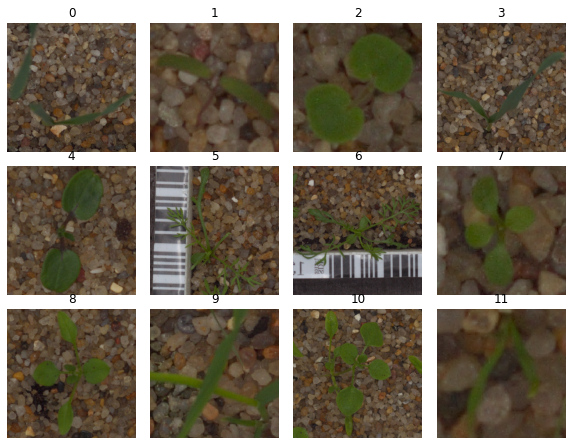

In [7]:
show_unique_grid(sample_data)
sample_data.class_indices

## 3.4 Class Distribution

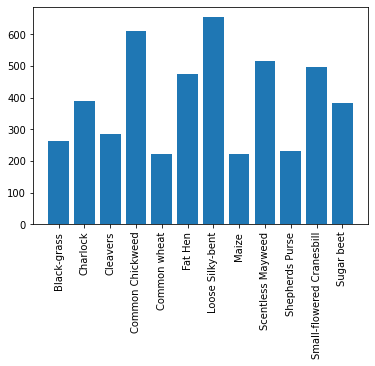

In [8]:
unique, counts = np.unique(sample_data.classes, return_counts=True)
dict1 = dict(zip(sample_data.class_indices, counts))

keys = dict1.keys()
values = dict1.values()

plt.xticks(rotation='vertical')
bar = plt.bar(keys, values)

# 4 Generating the CNN Model

## 4.1 Defining Model

Layer Structure for the Model is influenced by https://www.kaggle.com/ilyapozdnyakov/computer-vision-plants-cnn-visualisation 

In [9]:
def get_model():
    model = tf.keras.models.Sequential() #1
    model.add(tf.keras.layers.InputLayer(input_shape=(image_size,image_size,3,))) #2
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #3
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #4
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #5
    model.add(tf.keras.layers.BatchNormalization()) #6
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu')) #7
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #8
    model.add(tf.keras.layers.BatchNormalization()) #9
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) #10
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #11
    model.add(tf.keras.layers.BatchNormalization()) #12
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) #13
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) #14
    model.add(tf.keras.layers.GlobalMaxPool2D()) #15
    model.add(tf.keras.layers.Flatten()) #16 
    model.add(tf.keras.layers.Dense(128, activation='relu')) #17
    model.add(tf.keras.layers.Dropout(0.2)) #18
    model.add(tf.keras.layers.Dense(64, activation='relu')) #19
    model.add(tf.keras.layers.BatchNormalization()) #20
    model.add(tf.keras.layers.Dense(12, activation='softmax')) #21
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## 4.2 Model Summary

In [10]:
get_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 64)        2

## 4.3 Visualizing Model

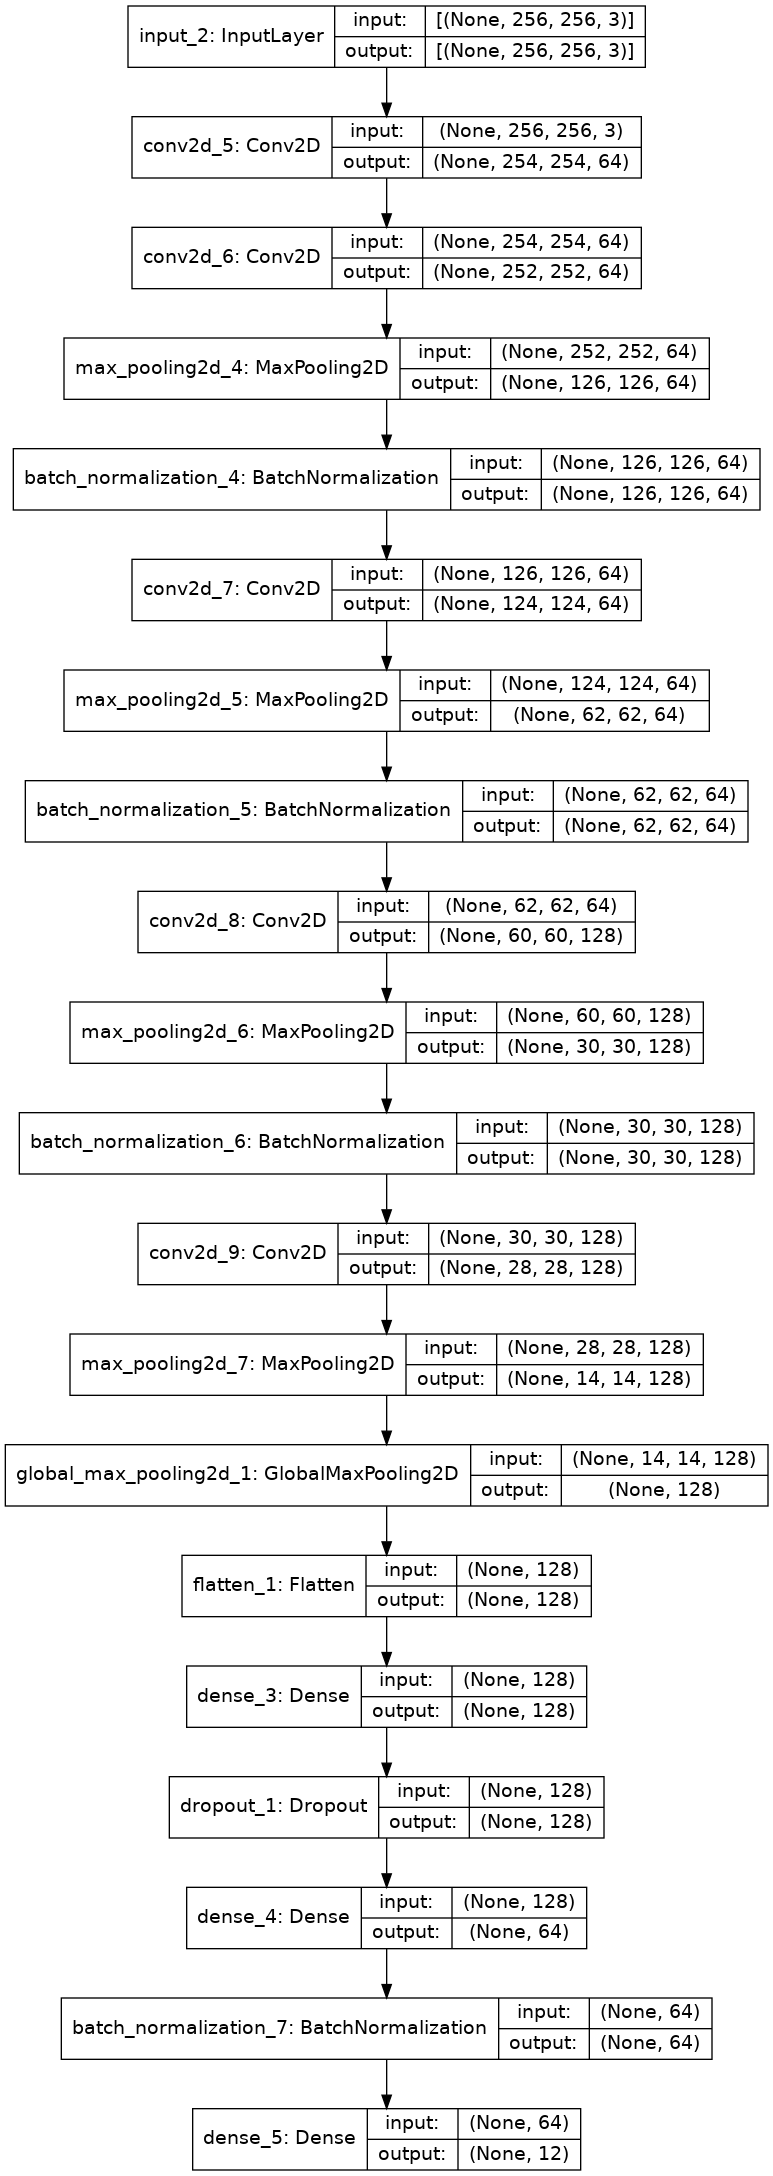

In [11]:
from keras.utils import plot_model
plot_model(get_model(), show_shapes=True, show_layer_names=True)

## 4.4 Evaluating the Model doing a 5 fold cross validation

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


kfold = KFold(n_splits=5, shuffle=True)
fold = 1
accuracies = []
rand_num = randrange(100000)
for train, test in kfold.split(training_img_list):
    model = get_model()
    idg = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.2
           )
    #Actual Training data for the model
    train_gen = idg.flow_from_dataframe(training_img_list.iloc[train,:],
                                        x_col="filename",
                                        y_col="class",
                                        subset='training',
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        shuffle=True,
                                        classes=classes
                                        )
    #Validation set for training the model, so the checkpoint can track the best model with max val accuracy
    val_gen   = idg.flow_from_dataframe(training_img_list.iloc[train,:],
                                        x_col="filename",
                                        y_col="class",
                                        subset='validation',
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        classes=classes
                                        )
    

    model_name = 'plant_classifier_'+str(rand_num)+'_fold_no_'+str(fold)+'.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1
                                                    )
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001)
    history = model.fit(train_gen,
                        epochs=20,
                        validation_data=val_gen,
                        callbacks = [checkpoint, es],
                        verbose = 1
                        )
    # Testing for the fold
    idg2 = tf.keras.preprocessing.image.ImageDataGenerator(
                        rescale=1./255,
                        horizontal_flip=True,
                        vertical_flip=True
                       )
    test_gen = idg2.flow_from_dataframe(training_img_list.iloc[test,:],
                                        x_col="filename",
                                        y_col="class",
                                        target_size=target_size,
                                        class_mode='categorical',
                                        batch_size=32,
                                        seed=1,
                                        classes=classes,
                                        shuffle=False
                                        )
    model.load_weights('./'+model_name)
    predictions = model.predict(test_gen, steps=test_gen.samples)
    y_pred = []
    for i in range(0, predictions.shape[0]):
      y_class = predictions[i, :].argmax(axis=-1)
      y_pred.append(y_class)
    accuracies.append(accuracy_score(test_gen.classes, y_pred))
    print('Accuracy for the fold ',fold, ': ', accuracies[fold-1])
    fold += 1

Found 3040 validated image filenames belonging to 12 classes.
Found 760 validated image filenames belonging to 12 classes.
Epoch 1/20
95/95 [==============================] - 133s 1s/step - loss: 2.7111 - accuracy: 0.1397 - val_loss: 2.4916 - val_accuracy: 0.1289

Epoch 00001: val_accuracy improved from -inf to 0.12895, saving model to plant_classifier_43838_fold_no_1.h5
Epoch 2/20
95/95 [==============================] - 105s 1s/step - loss: 1.8932 - accuracy: 0.3711 - val_loss: 3.1345 - val_accuracy: 0.1289

Epoch 00002: val_accuracy did not improve from 0.12895
Epoch 3/20
95/95 [==============================] - 104s 1s/step - loss: 1.2474 - accuracy: 0.5812 - val_loss: 5.7173 - val_accuracy: 0.1289

Epoch 00003: val_accuracy did not improve from 0.12895
Epoch 4/20
95/95 [==============================] - 105s 1s/step - loss: 1.0319 - accuracy: 0.6670 - val_loss: 4.6167 - val_accuracy: 0.1553

Epoch 00004: val_accuracy improved from 0.12895 to 0.15526, saving model to plant_classifi

## 4.5 Final 5-Cross Validation Score for the Model

In [13]:
print('5 fold accuracies= ', accuracies)
print('5 fold accuracy = ', np.mean(accuracies))

5 fold accuracies=  [0.871578947368421, 0.8252631578947368, 0.8852631578947369, 0.8168421052631579, 0.7473684210526316]
5 fold accuracy =  0.8292631578947368


# 5 Training the Model with full dataset

In [14]:
idg3 = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.2
           )
train_gen = idg3.flow_from_directory('../input/plant-seedlings-classification/train/',
                                                    target_size=target_size,
                                                    subset='training',
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=1,
                                                    classes=classes
                                                )
val_gen = idg3.flow_from_directory('../input/plant-seedlings-classification/train/',
                                                   target_size=(image_size, image_size),                                                   
                                                   subset='validation',
                                                   class_mode='categorical',
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   seed=1,
                                                   classes=classes
                                                )

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [15]:
model = get_model()

model_name = 'plant_classifier_fully_trained_'+str(randrange(100000))+'.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name, #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001)
history = model.fit(train_gen,
          epochs=30, # Increase number of epochs if you have sufficient hardware
          validation_data=val_gen,
          callbacks = [checkpoint, es],
          verbose = 1
)

Epoch 1/30
119/119 [==============================] - 141s 1s/step - loss: 2.4828 - accuracy: 0.2129 - val_loss: 2.9662 - val_accuracy: 0.1373

Epoch 00001: val_accuracy improved from -inf to 0.13728, saving model to plant_classifier_fully_trained_66317.h5
Epoch 2/30
119/119 [==============================] - 131s 1s/step - loss: 1.6516 - accuracy: 0.4332 - val_loss: 4.3096 - val_accuracy: 0.1373

Epoch 00002: val_accuracy did not improve from 0.13728
Epoch 3/30
119/119 [==============================] - 131s 1s/step - loss: 1.1311 - accuracy: 0.6349 - val_loss: 4.3358 - val_accuracy: 0.1785

Epoch 00003: val_accuracy improved from 0.13728 to 0.17846, saving model to plant_classifier_fully_trained_66317.h5
Epoch 4/30
119/119 [==============================] - 130s 1s/step - loss: 0.8414 - accuracy: 0.7293 - val_loss: 2.8023 - val_accuracy: 0.2724

Epoch 00004: val_accuracy improved from 0.17846 to 0.27244, saving model to plant_classifier_fully_trained_66317.h5
Epoch 5/30
119/119 [====

# 6 Visualizing the Output of the model before flattening


## 6.1 Getting the Model
Edit *layer_before_flattening* to have any layer before flattening to visualize the output from that layer

In [16]:
from keras.models import Model
layer_before_flattening = 10 #Edit this with the layer you need the visualization for

viz_model = Model(inputs=model.inputs, outputs=model.layers[layer_before_flattening].output)
viz_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 126, 126, 64)      0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 126, 126, 64)      256       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 62, 62, 64)        0     

## 6.2 Visualizing a Random Image on its original state.
Change the *image_no* to change the image(valid values: 0-31)

In [17]:
image_no = 14

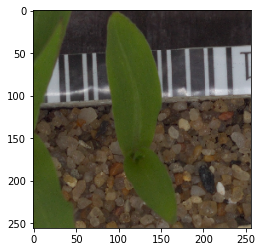

In [18]:
plt.imshow(train_gen[0][0][image_no])

## 6.3 Visualizing the features from the output layer for above image

In [19]:
nn = viz_model.predict(train_gen[0][0])

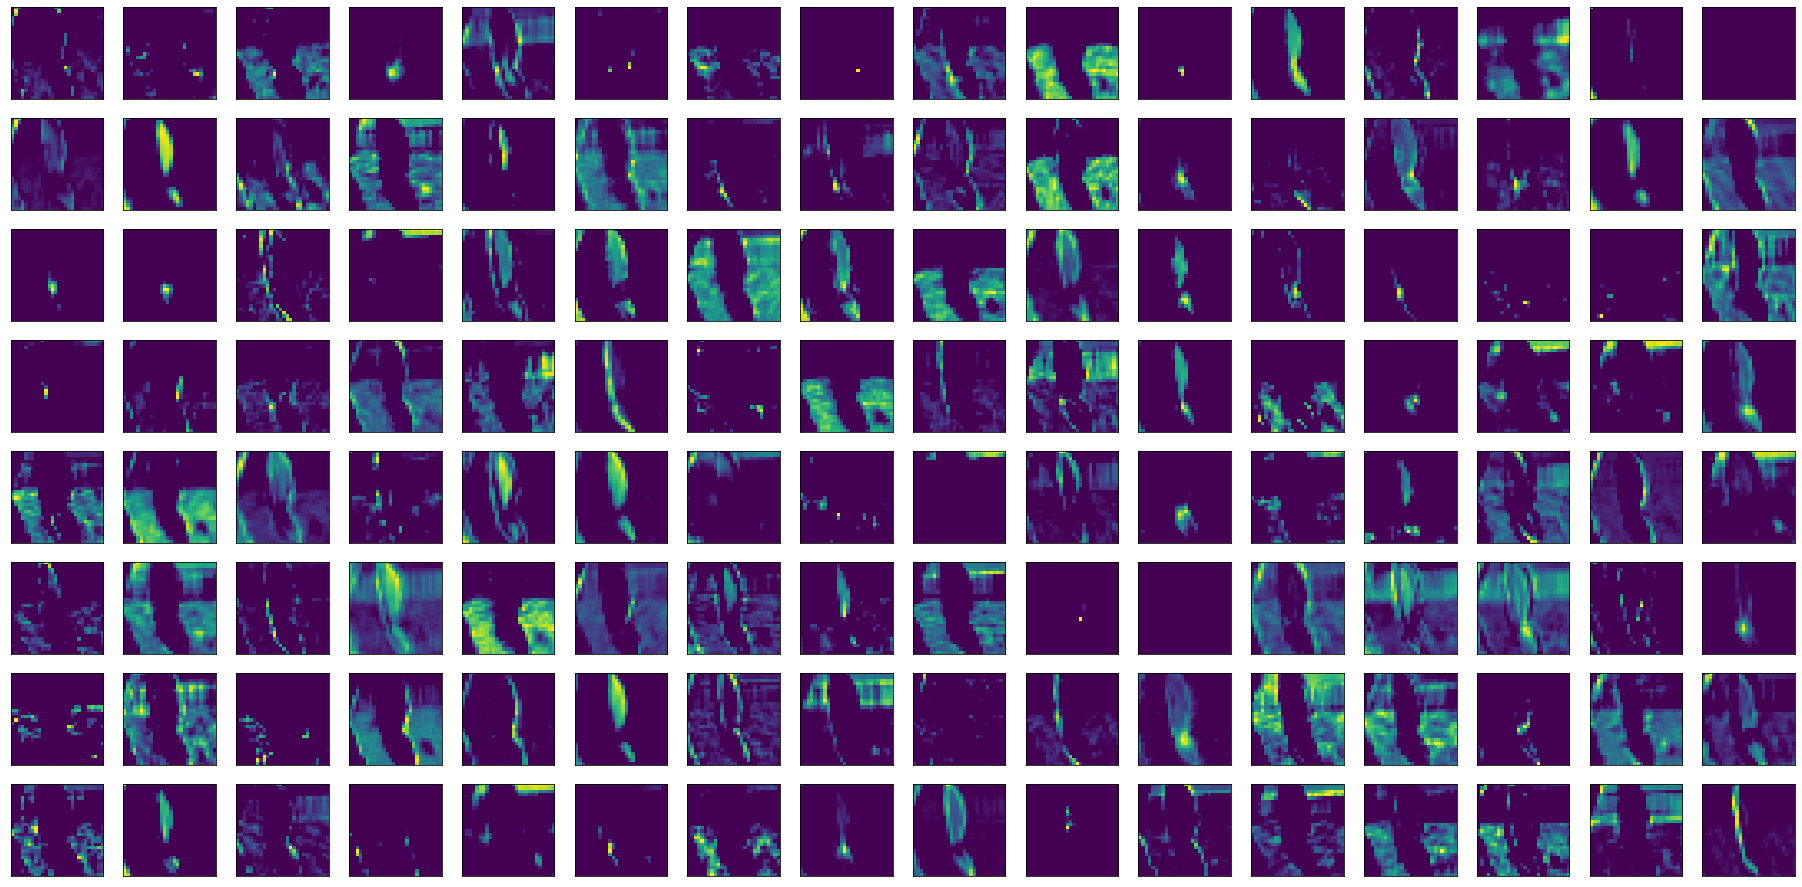

In [20]:
grid = (8, 16) 
ix = 1
fig = plt.figure(figsize=(32,16))
for _ in range(grid[0]):
    for _ in range(grid[1]):
        # specify subplot and turn of axis
        ax = fig.add_subplot(grid[0], grid[1], ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(nn[image_no, :, :, ix-1])
        ix += 1

plt.show()

# 7 Create Submission

## 7.1 Creating Data Generator for Test Data

In [21]:
idg4 = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True
           )
test_generator = idg4.flow_from_directory(
        directory='/kaggle/input/plant-seedlings-classification/',
        classes=['test'],
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical',
        seed=1)

Found 794 images belonging to 1 classes.


## 7.2 Loading the model and Creating Submission

model_name has the previously created model for training. But can replace with any model

In [22]:
final_model = get_model()
final_model.load_weights('./'+model_name)
predictions = final_model.predict(test_generator, steps=test_generator.samples)

class_list = []

for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [list(classes.keys())[y_class]]

submission = pd.DataFrame()
submission['file'] = test_generator.filenames
submission['file'] = submission['file'].str.replace(r'test/', '')
submission['species'] = class_list

submission.to_csv('submission.csv', index=False)